# In this notebook, I'll take my cleaned census geojson file to do some analysis and get the info I'll need to run my Google API. The main objectives are: 
### 1. Create a field that will show the top 7 population categories as percentages of the total population in each tract.
### 2. Create a subset of the data where the Black population is over 50% (these will serve as our predominantly Black areas when finding business types in the API).
### 3. In the subset, find the centroid of each polygon and the estimated radius of each polygon in meters (we will need these figures for the API as well. 
### 4. Export this to a new geojson file that I can use for reference when running the API.

In [40]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Geod
from shapely.geometry import Point, LineString
import folium

In [42]:
davidson_tract_geo = gpd.read_file('../data/davidson_race_by_tract/davidson_race_by_tract_clean.geojson')

In [45]:
davidson_tract_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   geoid       164 non-null    object  
 1   name        164 non-null    object  
 2   total_pop   164 non-null    float64 
 3   total_pop_  164 non-null    float64 
 4   white_alon  164 non-null    float64 
 5   white_al_1  164 non-null    float64 
 6   black_afri  164 non-null    float64 
 7   black_af_1  164 non-null    float64 
 8   nativeamer  164 non-null    float64 
 9   nativeam_1  164 non-null    float64 
 10  asian_alon  164 non-null    float64 
 11  asian_al_1  164 non-null    float64 
 12  hawaiian_p  164 non-null    float64 
 13  hawaiian_1  164 non-null    float64 
 14  other_alon  164 non-null    float64 
 15  other_al_1  164 non-null    float64 
 16  two_or_mor  164 non-null    float64 
 17  two_or_m_1  164 non-null    float64 
 18  two_includ  164 non-null    float64 
 19  

In [55]:
davidson_tract_geo.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [46]:
davidson_tract_geo['white_pct'] = (davidson_tract_geo['white_alon'])/(davidson_tract_geo['total_pop'])
davidson_tract_geo.head()

,geoid,name,total_pop,total_pop_,white_alon,white_al_1,black_afri,black_af_1,nativeamer,nativeam_1,...,other_alon,other_al_1,two_or_mor,two_or_m_1,two_includ,two_incl_1,two_exclud,two_excl_1,geometry,white_pct
0,01000US,United States,324697795.0,0.0,235377662.0,54551.0,41234642.0,32548.0,2750143.0,13011.0,...,16047369.0,97264.0,10763902.0,107388.0,1625998.0,28610.0,9137904.0,82541.0,"MULTIPOLYGON (((-168.22527 -14.53591, -168.199...",0.724913
1,04000US47,Tennessee,6709356.0,0.0,5205132.0,4583.0,1124473.0,3575.0,18189.0,1047.0,...,92655.0,4252.0,147536.0,3695.0,12138.0,1160.0,135398.0,3482.0,"POLYGON ((-82.22206 36.15696, -82.22214 36.156...",0.775802
2,05000US47037,"Davidson County, TN",687488.0,0.0,440299.0,1694.0,186295.0,1403.0,1534.0,404.0,...,16136.0,1796.0,17947.0,1444.0,1540.0,408.0,16407.0,1432.0,"MULTIPOLYGON (((-86.98361 36.20957, -86.98398 ...",0.640446
3,14000US47037010103,"Census Tract 101.03, Davidson, TN",2533.0,191.0,2457.0,201.0,7.0,10.0,8.0,14.0,...,0.0,12.0,45.0,42.0,0.0,12.0,45.0,42.0,"POLYGON ((-86.91752 36.33976, -86.91747 36.339...",0.969996
4,14000US47037010104,"Census Tract 101.04, Davidson, TN",2955.0,279.0,2713.0,268.0,167.0,136.0,16.0,25.0,...,0.0,12.0,40.0,42.0,22.0,33.0,18.0,24.0,"POLYGON ((-86.97440 36.24991, -86.97244 36.252...",0.918105


In [47]:
davidson_tract_geo['black_af_pct'] = (davidson_tract_geo['black_afri'])/(davidson_tract_geo['total_pop'])
davidson_tract_geo['nativeamer_pct'] = (davidson_tract_geo['nativeamer'])/(davidson_tract_geo['total_pop'])
davidson_tract_geo['asian_alon_pct'] = (davidson_tract_geo['asian_alon'])/(davidson_tract_geo['total_pop'])
davidson_tract_geo['hawaiian_p_pct'] = (davidson_tract_geo['hawaiian_p'])/(davidson_tract_geo['total_pop'])
davidson_tract_geo['other_alon_pct'] = (davidson_tract_geo['other_alon'])/(davidson_tract_geo['total_pop'])
davidson_tract_geo['two_or_mor_pct'] = (davidson_tract_geo['two_or_mor'])/(davidson_tract_geo['total_pop'])

In [48]:
davidson_tract_geo.head() #Checking to make sure it worked

,geoid,name,total_pop,total_pop_,white_alon,white_al_1,black_afri,black_af_1,nativeamer,nativeam_1,...,two_exclud,two_excl_1,geometry,white_pct,black_af_pct,nativeamer_pct,asian_alon_pct,hawaiian_p_pct,other_alon_pct,two_or_mor_pct
0,01000US,United States,324697795.0,0.0,235377662.0,54551.0,41234642.0,32548.0,2750143.0,13011.0,...,9137904.0,82541.0,"MULTIPOLYGON (((-168.22527 -14.53591, -168.199...",0.724913,0.126994,0.008470,0.055203,0.001847,0.049422,0.033151
1,04000US47,Tennessee,6709356.0,0.0,5205132.0,4583.0,1124473.0,3575.0,18189.0,1047.0,...,135398.0,3482.0,"POLYGON ((-82.22206 36.15696, -82.22214 36.156...",0.775802,0.167598,0.002711,0.017528,0.000562,0.013810,0.021990
2,05000US47037,"Davidson County, TN",687488.0,0.0,440299.0,1694.0,186295.0,1403.0,1534.0,404.0,...,16407.0,1432.0,"MULTIPOLYGON (((-86.98361 36.20957, -86.98398 ...",0.640446,0.270979,0.002231,0.036168,0.000599,0.023471,0.026105
3,14000US47037010103,"Census Tract 101.03, Davidson, TN",2533.0,191.0,2457.0,201.0,7.0,10.0,8.0,14.0,...,45.0,42.0,"POLYGON ((-86.91752 36.33976, -86.91747 36.339...",0.969996,0.002764,0.003158,0.006317,0.000000,0.000000,0.017765
4,14000US47037010104,"Census Tract 101.04, Davidson, TN",2955.0,279.0,2713.0,268.0,167.0,136.0,16.0,25.0,...,18.0,24.0,"POLYGON ((-86.97440 36.24991, -86.97244 36.252...",0.918105,0.056514,0.005415,0.005415,0.001015,0.000000,0.013536


### Identifying predominantly black tracts

In [49]:
davidson_pred_black = davidson_tract_geo[davidson_tract_geo['black_af_pct'] >= .5]
davidson_pred_black

,geoid,name,total_pop,total_pop_,white_alon,white_al_1,black_afri,black_af_1,nativeamer,nativeam_1,...,two_exclud,two_excl_1,geometry,white_pct,black_af_pct,nativeamer_pct,asian_alon_pct,hawaiian_p_pct,other_alon_pct,two_or_mor_pct
5,14000US47037010105,"Census Tract 101.05, Davidson, TN",4435.0,328.0,967.0,174.0,3317.0,354.0,0.0,12.0,...,90.0,82.0,"POLYGON ((-86.89144 36.26205, -86.89100 36.262...",0.218038,0.747914,0.000000,0.000000,0.000000,0.011048,0.022999
6,14000US47037010106,"Census Tract 101.06, Davidson, TN",3397.0,288.0,1020.0,184.0,2192.0,207.0,0.0,12.0,...,36.0,39.0,"POLYGON ((-86.83089 36.26570, -86.83016 36.265...",0.300265,0.645275,0.000000,0.003827,0.000000,0.040035,0.010598
23,14000US47037010903,"Census Tract 109.03, Davidson, TN",5863.0,648.0,503.0,195.0,4741.0,539.0,0.0,17.0,...,102.0,67.0,"POLYGON ((-86.78518 36.23812, -86.78502 36.239...",0.085792,0.808630,0.000000,0.002388,0.000000,0.085792,0.017397
24,14000US47037010904,"Census Tract 109.04, Davidson, TN",3213.0,236.0,564.0,257.0,2624.0,303.0,0.0,12.0,...,0.0,12.0,"POLYGON ((-86.78635 36.23788, -86.78634 36.237...",0.175537,0.816682,0.000000,0.004357,0.000000,0.003424,0.000000
25,14000US47037011001,"Census Tract 110.01, Davidson, TN",6746.0,726.0,2547.0,645.0,3561.0,650.0,22.0,34.0,...,118.0,87.0,"POLYGON ((-86.77646 36.20665, -86.77641 36.207...",0.377557,0.527868,0.003261,0.011711,0.000000,0.062111,0.017492
30,14000US47037011400,"Census Tract 114, Davidson, TN",4617.0,654.0,1944.0,354.0,2478.0,508.0,0.0,12.0,...,2.0,4.0,"POLYGON ((-86.74899 36.19845, -86.74874 36.198...",0.421053,0.536712,0.000000,0.000000,0.013212,0.028590,0.000433
34,14000US47037011800,"Census Tract 118, Davidson, TN",2700.0,409.0,880.0,334.0,1744.0,420.0,24.0,29.0,...,0.0,12.0,"POLYGON ((-86.77242 36.17674, -86.77234 36.176...",0.325926,0.645926,0.008889,0.015556,0.000000,0.003704,0.000000
35,14000US47037011900,"Census Tract 119, Davidson, TN",2530.0,322.0,1098.0,218.0,1323.0,256.0,0.0,12.0,...,28.0,29.0,"POLYGON ((-86.77081 36.17450, -86.77000 36.174...",0.433992,0.522925,0.000000,0.004743,0.000000,0.020949,0.017391
38,14000US47037012600,"Census Tract 126, Davidson, TN",2205.0,338.0,841.0,179.0,1246.0,248.0,6.0,9.0,...,104.0,75.0,"POLYGON ((-86.77627 36.19295, -86.77623 36.193...",0.381406,0.565079,0.002721,0.003628,0.000000,0.000000,0.047166
39,14000US47037012701,"Census Tract 127.01, Davidson, TN",6072.0,664.0,689.0,358.0,5243.0,783.0,16.0,25.0,...,89.0,119.0,"POLYGON ((-86.82143 36.22305, -86.82113 36.223...",0.113472,0.863472,0.002635,0.000000,0.000000,0.005764,0.014657


In [50]:
davidson_pred_black.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 25 entries, 5 to 158
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   geoid           25 non-null     object  
 1   name            25 non-null     object  
 2   total_pop       25 non-null     float64 
 3   total_pop_      25 non-null     float64 
 4   white_alon      25 non-null     float64 
 5   white_al_1      25 non-null     float64 
 6   black_afri      25 non-null     float64 
 7   black_af_1      25 non-null     float64 
 8   nativeamer      25 non-null     float64 
 9   nativeam_1      25 non-null     float64 
 10  asian_alon      25 non-null     float64 
 11  asian_al_1      25 non-null     float64 
 12  hawaiian_p      25 non-null     float64 
 13  hawaiian_1      25 non-null     float64 
 14  other_alon      25 non-null     float64 
 15  other_al_1      25 non-null     float64 
 16  two_or_mor      25 non-null     float64 
 17  two_or_m_

### I'm going to take the first census tract, plot the polygon and get the centroid. Then I'm going to create a column in the dataframe subset that includes the centroid for each polygon.  

In [51]:
ct_10105 = davidson_pred_black.loc[davidson_pred_black['name'] == 'Census Tract 101.05, Davidson, TN']
ct_10105.shape

(1, 30)

<AxesSubplot:>

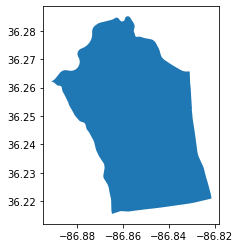

In [52]:
ct_10105.plot()

In [53]:
ct_10105.geometry.centroid

C:\Users\16159\AppData\Local\Temp/ipykernel_35420/2988246935.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ct_10105.geometry.centroid


5    POINT (-86.85388 36.24885)
dtype: geometry

In [56]:
davidson_pred_black['centroid'] = davidson_pred_black.geometry.centroid

C:\Users\16159\AppData\Local\Temp/ipykernel_35420/2848865303.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  davidson_pred_black['centroid'] = davidson_pred_black.geometry.centroid
C:\Users\16159\anaconda3\envs\geospatial\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [57]:
davidson_pred_black.head()

,geoid,name,total_pop,total_pop_,white_alon,white_al_1,black_afri,black_af_1,nativeamer,nativeam_1,...,two_excl_1,geometry,white_pct,black_af_pct,nativeamer_pct,asian_alon_pct,hawaiian_p_pct,other_alon_pct,two_or_mor_pct,centroid
5,14000US47037010105,"Census Tract 101.05, Davidson, TN",4435.0,328.0,967.0,174.0,3317.0,354.0,0.0,12.0,...,82.0,"POLYGON ((-86.89144 36.26205, -86.89100 36.262...",0.218038,0.747914,0.000000,0.000000,0.0,0.011048,0.022999,POINT (-86.85388 36.24885)
6,14000US47037010106,"Census Tract 101.06, Davidson, TN",3397.0,288.0,1020.0,184.0,2192.0,207.0,0.0,12.0,...,39.0,"POLYGON ((-86.83089 36.26570, -86.83016 36.265...",0.300265,0.645275,0.000000,0.003827,0.0,0.040035,0.010598,POINT (-86.80361 36.25371)
23,14000US47037010903,"Census Tract 109.03, Davidson, TN",5863.0,648.0,503.0,195.0,4741.0,539.0,0.0,17.0,...,67.0,"POLYGON ((-86.78518 36.23812, -86.78502 36.239...",0.085792,0.808630,0.000000,0.002388,0.0,0.085792,0.017397,POINT (-86.76382 36.24933)
24,14000US47037010904,"Census Tract 109.04, Davidson, TN",3213.0,236.0,564.0,257.0,2624.0,303.0,0.0,12.0,...,12.0,"POLYGON ((-86.78635 36.23788, -86.78634 36.237...",0.175537,0.816682,0.000000,0.004357,0.0,0.003424,0.000000,POINT (-86.77321 36.23432)
25,14000US47037011001,"Census Tract 110.01, Davidson, TN",6746.0,726.0,2547.0,645.0,3561.0,650.0,22.0,34.0,...,87.0,"POLYGON ((-86.77646 36.20665, -86.77641 36.207...",0.377557,0.527868,0.003261,0.011711,0.0,0.062111,0.017492,POINT (-86.75983 36.22296)


<AxesSubplot:>

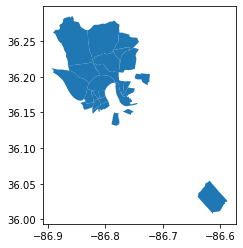

In [58]:
polygon = davidson_geo_pred_black
polygon.plot() #checking all the polygons

In [61]:
test_map = folium.Map([36.1612, -86.7775], zoom_start=11)
folium.GeoJson(polygon).add_to(test_map)
test_map  #plotting polygons on a folium map to get an idea of where they are in Nashville.

### Now I will attempt to get an approximate radius for each polygon.

In [62]:
tost = davidson_geo_pred_black.copy() #creating a copy
tost= tost.to_crs('epsg:26916') #projecting it to a crs we can use for meters, information found here: https://epsg.io/26916-1733
print(tost.crs)
tost.head()

epsg:26916


,geoid,name,total_pop,total_pop_,white_alon,white_al_1,black_afri,black_af_1,geometry,white_pct,white_error_pct,black_af_pct,black_af_error_pct
5,14000US47037010105,"Census Tract 101.05, Davidson, TN",4435.0,328.0,967.0,174.0,3317.0,354.0,"POLYGON ((509751.590 4013020.256, 509790.998 4...",0.218038,0.039233,0.747914,0.079820
6,14000US47037010106,"Census Tract 101.06, Davidson, TN",3397.0,288.0,1020.0,184.0,2192.0,207.0,"POLYGON ((515190.360 4013432.237, 515255.934 4...",0.300265,0.054165,0.645275,0.060936
23,14000US47037010903,"Census Tract 109.03, Davidson, TN",5863.0,648.0,503.0,195.0,4741.0,539.0,"POLYGON ((519303.013 4010382.103, 519317.394 4...",0.085792,0.033259,0.808630,0.091932
24,14000US47037010904,"Census Tract 109.04, Davidson, TN",3213.0,236.0,564.0,257.0,2624.0,303.0,"POLYGON ((519198.030 4010355.139, 519198.380 4...",0.175537,0.079988,0.816682,0.094304
25,14000US47037011001,"Census Tract 110.01, Davidson, TN",6746.0,726.0,2547.0,645.0,3561.0,650.0,"POLYGON ((520094.157 4006892.258, 520098.726 4...",0.377557,0.095612,0.527868,0.096353


### The geometry.length method in geopandas will get the length between 2 points. For a polygon, it will sum the lengths of the sides. I am going to use this as the "circumfrence" of the polygon, and then use the formula for radius (r = C/2pi) to get the approximate radius of each polygon. It will not be exact, but again we are just using it to get an approximate radius for the Google Places API. I'm going to add a 1/2 mile buffer, and when I am compiling all of my businesses I will drop any duplicates. Once all points are plotted on the map, we'll be able to see where everything is located and we can drop outliers if needed. 

In [63]:
tost['length'] = tost.geometry.length
tost.head()

,geoid,name,total_pop,total_pop_,white_alon,white_al_1,black_afri,black_af_1,geometry,white_pct,white_error_pct,black_af_pct,black_af_error_pct,length
5,14000US47037010105,"Census Tract 101.05, Davidson, TN",4435.0,328.0,967.0,174.0,3317.0,354.0,"POLYGON ((509751.590 4013020.256, 509790.998 4...",0.218038,0.039233,0.747914,0.079820,23435.043498
6,14000US47037010106,"Census Tract 101.06, Davidson, TN",3397.0,288.0,1020.0,184.0,2192.0,207.0,"POLYGON ((515190.360 4013432.237, 515255.934 4...",0.300265,0.054165,0.645275,0.060936,20044.091050
23,14000US47037010903,"Census Tract 109.03, Davidson, TN",5863.0,648.0,503.0,195.0,4741.0,539.0,"POLYGON ((519303.013 4010382.103, 519317.394 4...",0.085792,0.033259,0.808630,0.091932,12008.856658
24,14000US47037010904,"Census Tract 109.04, Davidson, TN",3213.0,236.0,564.0,257.0,2624.0,303.0,"POLYGON ((519198.030 4010355.139, 519198.380 4...",0.175537,0.079988,0.816682,0.094304,8784.275600
25,14000US47037011001,"Census Tract 110.01, Davidson, TN",6746.0,726.0,2547.0,645.0,3561.0,650.0,"POLYGON ((520094.157 4006892.258, 520098.726 4...",0.377557,0.095612,0.527868,0.096353,11914.003487


In [64]:
tost['radius'] = (tost.length) / (2*3.14156) #Formula for radius
tost.head()

,geoid,name,total_pop,total_pop_,white_alon,white_al_1,black_afri,black_af_1,geometry,white_pct,white_error_pct,black_af_pct,black_af_error_pct,length,radius
5,14000US47037010105,"Census Tract 101.05, Davidson, TN",4435.0,328.0,967.0,174.0,3317.0,354.0,"POLYGON ((509751.590 4013020.256, 509790.998 4...",0.218038,0.039233,0.747914,0.079820,23435.043498,3729.841782
6,14000US47037010106,"Census Tract 101.06, Davidson, TN",3397.0,288.0,1020.0,184.0,2192.0,207.0,"POLYGON ((515190.360 4013432.237, 515255.934 4...",0.300265,0.054165,0.645275,0.060936,20044.091050,3190.149329
23,14000US47037010903,"Census Tract 109.03, Davidson, TN",5863.0,648.0,503.0,195.0,4741.0,539.0,"POLYGON ((519303.013 4010382.103, 519317.394 4...",0.085792,0.033259,0.808630,0.091932,12008.856658,1911.288764
24,14000US47037010904,"Census Tract 109.04, Davidson, TN",3213.0,236.0,564.0,257.0,2624.0,303.0,"POLYGON ((519198.030 4010355.139, 519198.380 4...",0.175537,0.079988,0.816682,0.094304,8784.275600,1398.075415
25,14000US47037011001,"Census Tract 110.01, Davidson, TN",6746.0,726.0,2547.0,645.0,3561.0,650.0,"POLYGON ((520094.157 4006892.258, 520098.726 4...",0.377557,0.095612,0.527868,0.096353,11914.003487,1896.192256


In [65]:
tost['buffer'] = tost.radius + 805 # A half mile is about 805 meters
tost.head()

,geoid,name,total_pop,total_pop_,white_alon,white_al_1,black_afri,black_af_1,geometry,white_pct,white_error_pct,black_af_pct,black_af_error_pct,length,radius,buffer
5,14000US47037010105,"Census Tract 101.05, Davidson, TN",4435.0,328.0,967.0,174.0,3317.0,354.0,"POLYGON ((509751.590 4013020.256, 509790.998 4...",0.218038,0.039233,0.747914,0.079820,23435.043498,3729.841782,4534.841782
6,14000US47037010106,"Census Tract 101.06, Davidson, TN",3397.0,288.0,1020.0,184.0,2192.0,207.0,"POLYGON ((515190.360 4013432.237, 515255.934 4...",0.300265,0.054165,0.645275,0.060936,20044.091050,3190.149329,3995.149329
23,14000US47037010903,"Census Tract 109.03, Davidson, TN",5863.0,648.0,503.0,195.0,4741.0,539.0,"POLYGON ((519303.013 4010382.103, 519317.394 4...",0.085792,0.033259,0.808630,0.091932,12008.856658,1911.288764,2716.288764
24,14000US47037010904,"Census Tract 109.04, Davidson, TN",3213.0,236.0,564.0,257.0,2624.0,303.0,"POLYGON ((519198.030 4010355.139, 519198.380 4...",0.175537,0.079988,0.816682,0.094304,8784.275600,1398.075415,2203.075415
25,14000US47037011001,"Census Tract 110.01, Davidson, TN",6746.0,726.0,2547.0,645.0,3561.0,650.0,"POLYGON ((520094.157 4006892.258, 520098.726 4...",0.377557,0.095612,0.527868,0.096353,11914.003487,1896.192256,2701.192256


In [66]:
tost.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 25 entries, 5 to 158
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   geoid               25 non-null     object  
 1   name                25 non-null     object  
 2   total_pop           25 non-null     float64 
 3   total_pop_          25 non-null     float64 
 4   white_alon          25 non-null     float64 
 5   white_al_1          25 non-null     float64 
 6   black_afri          25 non-null     float64 
 7   black_af_1          25 non-null     float64 
 8   geometry            25 non-null     geometry
 9   white_pct           25 non-null     float64 
 10  white_error_pct     25 non-null     float64 
 11  black_af_pct        25 non-null     float64 
 12  black_af_error_pct  25 non-null     float64 
 13  length              25 non-null     float64 
 14  radius              25 non-null     float64 
 15  buffer              25 non-null  

### Now I will add my newly created columns (radius & buffer) to my davidson_pred_black dataframe and export it to file.

In [67]:
davidson_pred_black['radius'] = tost.radius
davidson_pred_black.head()

C:\Users\16159\anaconda3\envs\geospatial\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,geoid,name,total_pop,total_pop_,white_alon,white_al_1,black_afri,black_af_1,nativeamer,nativeam_1,...,geometry,white_pct,black_af_pct,nativeamer_pct,asian_alon_pct,hawaiian_p_pct,other_alon_pct,two_or_mor_pct,centroid,radius
5,14000US47037010105,"Census Tract 101.05, Davidson, TN",4435.0,328.0,967.0,174.0,3317.0,354.0,0.0,12.0,...,"POLYGON ((-86.89144 36.26205, -86.89100 36.262...",0.218038,0.747914,0.000000,0.000000,0.0,0.011048,0.022999,POINT (-86.85388 36.24885),3729.841782
6,14000US47037010106,"Census Tract 101.06, Davidson, TN",3397.0,288.0,1020.0,184.0,2192.0,207.0,0.0,12.0,...,"POLYGON ((-86.83089 36.26570, -86.83016 36.265...",0.300265,0.645275,0.000000,0.003827,0.0,0.040035,0.010598,POINT (-86.80361 36.25371),3190.149329
23,14000US47037010903,"Census Tract 109.03, Davidson, TN",5863.0,648.0,503.0,195.0,4741.0,539.0,0.0,17.0,...,"POLYGON ((-86.78518 36.23812, -86.78502 36.239...",0.085792,0.808630,0.000000,0.002388,0.0,0.085792,0.017397,POINT (-86.76382 36.24933),1911.288764
24,14000US47037010904,"Census Tract 109.04, Davidson, TN",3213.0,236.0,564.0,257.0,2624.0,303.0,0.0,12.0,...,"POLYGON ((-86.78635 36.23788, -86.78634 36.237...",0.175537,0.816682,0.000000,0.004357,0.0,0.003424,0.000000,POINT (-86.77321 36.23432),1398.075415
25,14000US47037011001,"Census Tract 110.01, Davidson, TN",6746.0,726.0,2547.0,645.0,3561.0,650.0,22.0,34.0,...,"POLYGON ((-86.77646 36.20665, -86.77641 36.207...",0.377557,0.527868,0.003261,0.011711,0.0,0.062111,0.017492,POINT (-86.75983 36.22296),1896.192256


In [69]:
davidson_pred_black['buffer'] = davidson_pred_black['radius'] + 805
davidson_pred_black.head()

C:\Users\16159\anaconda3\envs\geospatial\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,geoid,name,total_pop,total_pop_,white_alon,white_al_1,black_afri,black_af_1,nativeamer,nativeam_1,...,white_pct,black_af_pct,nativeamer_pct,asian_alon_pct,hawaiian_p_pct,other_alon_pct,two_or_mor_pct,centroid,radius,buffer
5,14000US47037010105,"Census Tract 101.05, Davidson, TN",4435.0,328.0,967.0,174.0,3317.0,354.0,0.0,12.0,...,0.218038,0.747914,0.000000,0.000000,0.0,0.011048,0.022999,POINT (-86.85388 36.24885),3729.841782,4534.841782
6,14000US47037010106,"Census Tract 101.06, Davidson, TN",3397.0,288.0,1020.0,184.0,2192.0,207.0,0.0,12.0,...,0.300265,0.645275,0.000000,0.003827,0.0,0.040035,0.010598,POINT (-86.80361 36.25371),3190.149329,3995.149329
23,14000US47037010903,"Census Tract 109.03, Davidson, TN",5863.0,648.0,503.0,195.0,4741.0,539.0,0.0,17.0,...,0.085792,0.808630,0.000000,0.002388,0.0,0.085792,0.017397,POINT (-86.76382 36.24933),1911.288764,2716.288764
24,14000US47037010904,"Census Tract 109.04, Davidson, TN",3213.0,236.0,564.0,257.0,2624.0,303.0,0.0,12.0,...,0.175537,0.816682,0.000000,0.004357,0.0,0.003424,0.000000,POINT (-86.77321 36.23432),1398.075415,2203.075415
25,14000US47037011001,"Census Tract 110.01, Davidson, TN",6746.0,726.0,2547.0,645.0,3561.0,650.0,22.0,34.0,...,0.377557,0.527868,0.003261,0.011711,0.0,0.062111,0.017492,POINT (-86.75983 36.22296),1896.192256,2701.192256


In [74]:
davidson_pred_black.centroid = davidson_pred_black.centroid.astype(str) # You cannot save a geodataframe with 2 geometry fields, so I will convert the centroid field to a string. 
davidson_pred_black.head()

C:\Users\16159\AppData\Local\Temp/ipykernel_35420/4241037988.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  davidson_pred_black.centroid = davidson_pred_black.centroid.astype(str) # You cannot save a geodataframe with 2 geometry fields, so I will convert the centroid field to a string.
C:\Users\16159\anaconda3\envs\geospatial\lib\site-packages\pandas\core\generic.py:5499: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  object.__getattribute__(self, name)
C:\Users\16159\anaconda3\envs\geospatial\lib\site-packages\pandas\core\generic.py:5512: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before 

,geoid,name,total_pop,total_pop_,white_alon,white_al_1,black_afri,black_af_1,nativeamer,nativeam_1,...,white_pct,black_af_pct,nativeamer_pct,asian_alon_pct,hawaiian_p_pct,other_alon_pct,two_or_mor_pct,centroid,radius,buffer
5,14000US47037010105,"Census Tract 101.05, Davidson, TN",4435.0,328.0,967.0,174.0,3317.0,354.0,0.0,12.0,...,0.218038,0.747914,0.000000,0.000000,0.0,0.011048,0.022999,POINT (-86.85387694867056 36.24885011739272),3729.841782,4534.841782
6,14000US47037010106,"Census Tract 101.06, Davidson, TN",3397.0,288.0,1020.0,184.0,2192.0,207.0,0.0,12.0,...,0.300265,0.645275,0.000000,0.003827,0.0,0.040035,0.010598,POINT (-86.80361436262159 36.25371488856965),3190.149329,3995.149329
23,14000US47037010903,"Census Tract 109.03, Davidson, TN",5863.0,648.0,503.0,195.0,4741.0,539.0,0.0,17.0,...,0.085792,0.808630,0.000000,0.002388,0.0,0.085792,0.017397,POINT (-86.76382269139667 36.24932859655561),1911.288764,2716.288764
24,14000US47037010904,"Census Tract 109.04, Davidson, TN",3213.0,236.0,564.0,257.0,2624.0,303.0,0.0,12.0,...,0.175537,0.816682,0.000000,0.004357,0.0,0.003424,0.000000,POINT (-86.77321059142152 36.23431733718186),1398.075415,2203.075415
25,14000US47037011001,"Census Tract 110.01, Davidson, TN",6746.0,726.0,2547.0,645.0,3561.0,650.0,22.0,34.0,...,0.377557,0.527868,0.003261,0.011711,0.0,0.062111,0.017492,POINT (-86.75982876080599 36.22296311702502),1896.192256,2701.192256


In [75]:
davidson_pred_black.to_file('../data/davidson_race_by_tract/davidson_tracts_pred_black.geojson')